In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.special as spsp
import scipy.stats as spst
from statsmodels.formula.api import poisson, negativebinomial, ols, logit
from statsmodels.base.model import GenericLikelihoodModel

# Setting 

In this problem we will examine [data](https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats) collected during A/B testing of the [Cookie Cats](https://tactilegames.com/cookie-cats/) game. We have information on 90,189 players who installed the game. The variables are as follows:

* **userid**: A unique number that identifies each player.
* **version**: gate30 (gate at level 30) or gate40 (gate at level 40). This delineates the two user groups.
* **retention_1**: Did the player come back and play 1 day after installing?
* **retention_7**: Did the player come back and play 7 days after installing?


In [3]:
Cookie = pd.read_csv("cookie_cats.csv")
Cookie

,userid,version,retention_1,retention_7
0,116,gate_30,False,False
1,337,gate_30,True,False
2,377,gate_40,True,False
3,483,gate_40,False,False
4,488,gate_40,True,True
...,...,...,...,...
90183,9999441,gate_40,True,False
90184,9999479,gate_40,False,False
90185,9999710,gate_30,True,False
90186,9999768,gate_40,True,False


We will be using the `Cookie` data to simulate a 2-armed bandit, implemented below. When we "pull an arm", we will sample a user with the corresponding **version**, and one of their **retention** values will serve as a 1/0 reward corresponding to True or False.

When initializing a `Cookie_Bandit`, we pass in two lists, one containing the reward samples of the `gate_30` **version** and the other containing the `group_40` **version**. Then `pull_arm()` samples from the indicated group using `np.random.choice()`.

In [4]:
class Cookie_Bandit:
    def __init__(self, data_A, data_B):
        self.data_A = data_A
        self.data_B = data_B
    def pull_arm(self, i):
        if i == 0:
            return np.random.choice(self.data_A)
        else:
            return np.random.choice(self.data_B)

# Part 1 [10 pts]

Implement a UCB action selection strategy for simulating this bandit. We recommend that you use the lecture implementation as a starting point, but you need to modify it as follows.

* `ucb()` stores and subsequently returns the Q and U values of *both* arms at every trial. So you should be returning 4 separate arrays (you can also stack them into 2D arrays), each of length `trials`. 

* `run_ucb()` calls `ucb()` `sims` times to acquire the average Q- and U-values. It should then generate two plots, one showing the two Q-value curves, the other showing the two U-value curves.

It is not necessary for `ucb()` to return regret, nor for `run_experiment()` to iterate over multiple `alpha` values.

In [5]:
mean1_here_test = Cookie.groupby('version')['retention_1'].mean()
print(mean1_here_test)
mean2_here_test = Cookie.groupby('version')['retention_7'].mean()
print(mean2_here_test)

version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64
version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64


In [6]:
def ucb(bandit, alpha, trials):
    K = 2
    Q0, Q1, U0, U1 = np.zeros(trials), np.zeros(trials), np.zeros(trials), np.zeros(trials)

    Q = np.zeros(K)
    N = np.ones(K)        
    for k in range(K):
        Q[k] = bandit.pull_arm(k)

    for n in range(K, trials):
        idx = np.argmax(Q + np.sqrt(alpha*np.log(n)/N))
        reward = bandit.pull_arm(idx)
        N[idx] += 1
        Q[idx] += 1/N[idx] * (reward - Q[idx])

        Q0[n], Q1[n] = Q
        U0[n], U1[n] = np.sqrt(alpha*np.log(n)/N)

    return Q0, Q1, U0, U1

In [7]:
def run_ucb(bandit, alpha, trials, sims):
    # I saw it's not nessicery to iterate over multiple a values now, just understood it as it's still allowed to do this. If now, simply removing the first for look and change the 'a' to 'alpha' and it should work.
    for a in alphas:
        avg_Q0, avg_Q1, avg_U0, avg_U1 = np.zeros(trials), np.zeros(trials), np.zeros(trials), np.zeros(trials)
        for m in range(sims):
            Q0, Q1, U0, U1 = ucb(bandit, a, trials)
            avg_Q0 += Q0
            avg_Q1 += Q1
            avg_U0 += U0
            avg_U1 += U1

        avg_Q0 /= sims
        avg_Q1 /= sims
        avg_U0 /= sims
        avg_U1 /= sims

        plt.plot(avg_Q0, label = 'Q gate_30, a=%.2f'%a)
        plt.plot(avg_Q1, label = 'Q gate_40, a=%.2f'%a)
        plt.xscale("log")
        plt.legend()
        plt.show()

        plt.plot(avg_U0, label = 'U gate_30, a=%.2f'%a)
        plt.plot(avg_U1, label = 'U gate_40, a=%.2f'%a)
        plt.xscale("log")
        plt.legend()
        plt.show()

# Part 2 [8 pts]

Run your bandit simulator in two different settings. One should treat **retention_1** as the reward, and the other should use **retention_7**.

* Run both settings for 10000 trials and 100 simulations, and show the resultant Q- and U-value plots.

* Briefly describe your observations. Do the Q-values converge toward the true mean values of each group? Do we become more certain about our estimates over time? Does it become clear which **version** is optimal for maximizing each of the **retention** values over time?

In [8]:
r1g30=Cookie.loc[Cookie['version'] == 'gate_30', 'retention_1']
r1g40=Cookie.loc[Cookie['version'] == 'gate_40', 'retention_1']
r7g30=Cookie.loc[Cookie['version'] == 'gate_30', 'retention_7']
r7g40=Cookie.loc[Cookie['version'] == 'gate_40', 'retention_7']
r1bandit = Cookie_Bandit(r1g30, r1g40)
r7bandit = Cookie_Bandit(r7g30, r7g40)

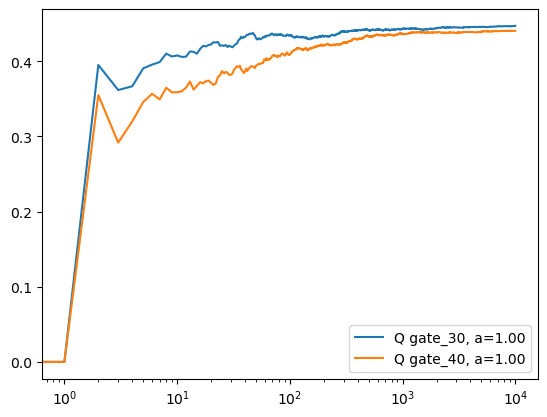

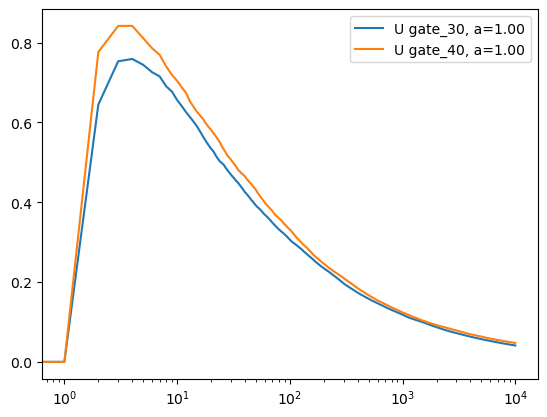

r7


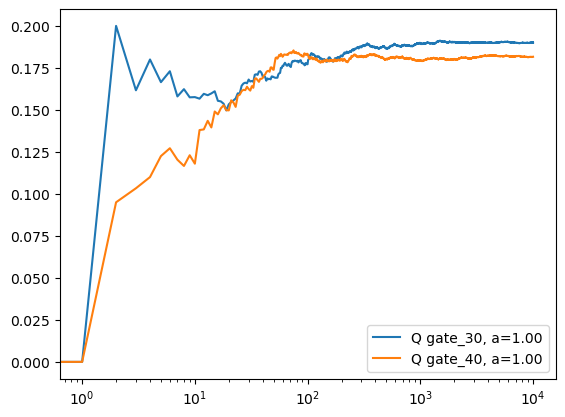

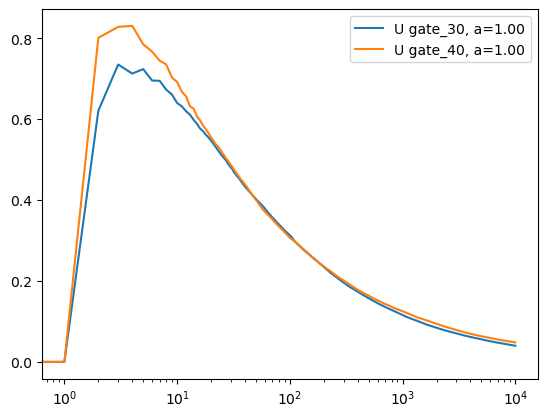

In [9]:
alphas = [1] # [0.1, 0.5, 1], was told only need alphas = 1, my code could work for multiple a as well.
trials, sims = 10000, 100
run_ucb(r1bandit, alphas, trials, sims)
print('r7')
run_ucb(r7bandit, alphas, trials, sims)

Yes, Q-values converge toward around the true mean values as we can see from the plot and what we printed at the beginning of Part 1, and we become more certain about our estimates over time as we can see U is decreasing overtime for both cases, uncertainty is decreasing over time. I would say it's kind of clear as seems like we're getting stable as time goes by and gate_30 is always higher as gate_40, for both retention_1 and retention_7, they are close though. Thus we might want to say gate_30 is optimal, for maximizing both retention_1 and retention_7 over time (might be clearer for retention_7 as the difference is more obvious).

# Part 3 [10 pts]

We can also model our rewards as being drawn from a Bernoulli distribution. Thus, another bandit strategy would be to use Thompson sampling with a beta prior distribution. Implement this scheme as follows:

* `thompson()` stores and subsequently returns the $a$ and $b$ parameter values of *both* arms at every trial. So you should be returning 4 separate arrays (you can also stack them into 2D arrays), each of length `trials`. 

* `run_thompson()` calls `thompson()` `sims` times to acquire the average parameter values. It should then generate two plots: 
    * One shows two curves tracking the average *expected value* of the two beta distributions: $E(\tilde\theta_i) = \frac{a_i}{a_i+b_i}$. 
    * The other shows the PDFs of the two beta distributions in the *last* trial. The $\tilde\theta$ axis should range from 0 to 1 on a linear scale.


In [9]:
def thompson(bandit, trials):
    K = 2
    params = np.ones((K,2))
    a = np.zeros((K,trials))
    b = np.zeros((K,trials))

    for n in range(trials):
        samples = np.random.beta(params[:,0], params[:,1])
        idx = np.argmax(samples)

        reward = bandit.pull_arm(idx)
        params[idx,0] += reward
        params[idx,1] += 1-reward

        a[:, n] = params[:, 0]
        b[:, n] = params[:, 1]

    return a, b

In [10]:
def run_thompson(bandit, trials, sims):
    avg_a, avg_b = np.zeros((2, trials)), np.zeros((2, trials))
    cum_a, cum_b = 0, 0
    for m in range(sims):    
        avg_a, avg_b = thompson(bandit, trials)
        cum_a += avg_a
        cum_b += avg_b
    avg_a = cum_a/sims 
    avg_b = cum_b/sims
    exp_r = avg_a / (avg_a + avg_b) 

    plt.plot(exp_r[0], label = 'gate_30')
    plt.plot(exp_r[1], label = 'gate_40')
    plt.legend()
    plt.show()

    theta = np.linspace(0, 1, 100)
    final_a = avg_a[:, -1]
    final_b = avg_b[:, -1]

    pdfa = spst.beta.pdf(theta, final_a[0], final_b[0])
    pdfb = spst.beta.pdf(theta, final_a[1], final_b[1])
    
    plt.plot(pdfa, label = 'gate_30')
    plt.plot(pdfb, label = 'gate_40')
    plt.legend()
    plt.show()

# Part 4 [8 pts]

As in Part 2, run Thomson sampling in two different settings, one with **retention_1** as the reward, and the other with **retention_7**.

* Run both settings for 10000 trials and 100 simulations, and show the resultant plots.

* Briefly describe your observations. Do the expected values of the estimated rewards converge toward the true mean values of each group? What do the final beta distributions tell us about the estimated reward distributions?

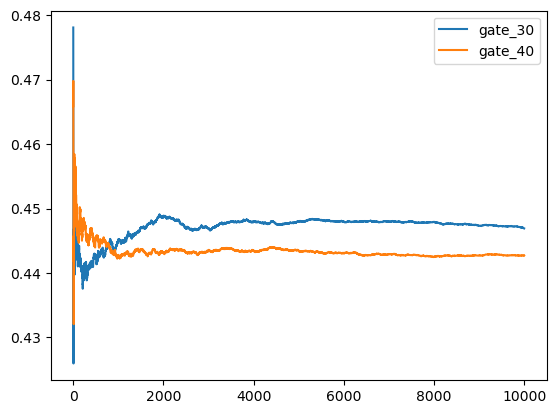

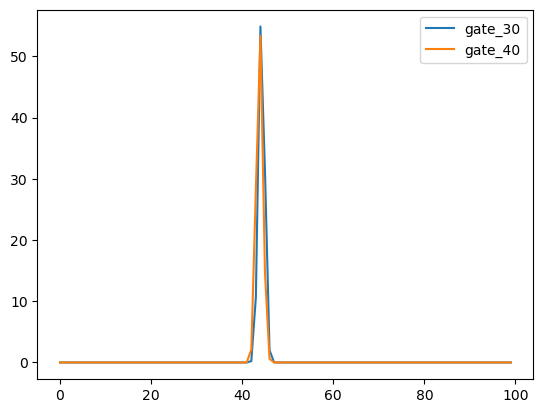

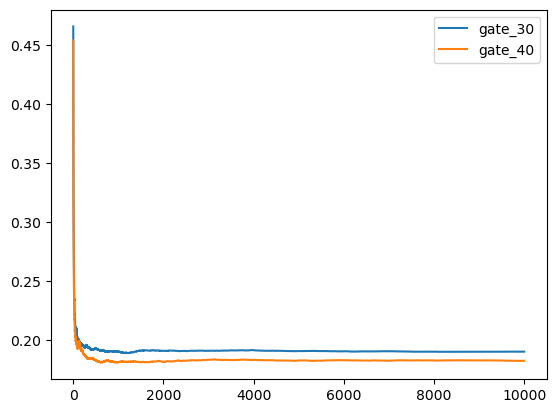

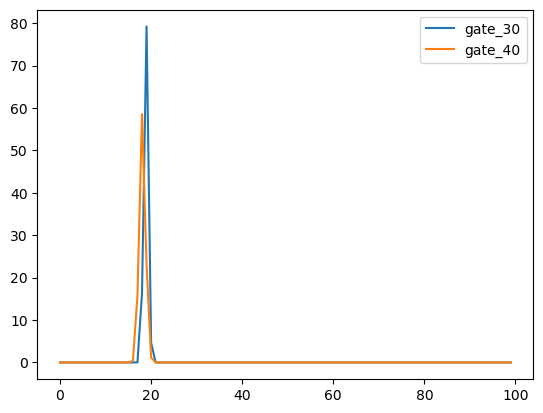

In [11]:
run_thompson(r1bandit, 10000, 100)
run_thompson(r7bandit, 10000, 100)
# or set things like trails = 10000, sims = 100, run_thompson(r1bandit, trails, sims) and same for retention_7, just I didn't do that when running.

Briefly describe your observations. Do the expected values of the estimated rewards converge toward the true mean values of each group? What do the final beta distributions tell us about the estimated reward distributions?

Yes, as we can see from the plot, the expected values of the estimated rewards converge toward the true mean values of each group, comparing with the value we printed at the beginning of part 1 (might even closer to the true mean value than part 2). Also, we still observed the same thing that for the avg expected value,  they both kind of stabalized ended up, while converging at the kind of end we say gate_30 higher tha gate_40, clearer this time that part 2 as well, so we might say we get the same as what we have at the end of part 2 answer. While for the beta distribution pdf plot, we see a spike and kind of around 0 other times. From this we might want to say that the estimated reward distribution for both became highly concentrated aruond a specific value, we want to say that this shows that it's pretty confident about the estimated avg reward (assumed no need to eaplain in super detailed way).  

In [12]:
# No need to rerun this cell I feel, I didn't rerun, but just in case still put it here.

r1g30=Cookie.loc[Cookie['version'] == 'gate_30', 'retention_1']
r1g40=Cookie.loc[Cookie['version'] == 'gate_40', 'retention_1']
r7g30=Cookie.loc[Cookie['version'] == 'gate_30', 'retention_7']
r7g40=Cookie.loc[Cookie['version'] == 'gate_40', 'retention_7']
r1bandit = Cookie_Bandit(r1g30, r1g40)
r7bandit = Cookie_Bandit(r7g30, r7g40)